In [21]:
import pandas as pd
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as mplPolygon
from cartopy.mpl.geoaxes import GeoAxes
from metpy.plots import USCOUNTIES
import datetime
import numpy as np

     Time Speed          Location        County State   LAT   LON  \
0    1200   UNK           ASHLAND          CLAY    AL  3328  8584   
1    1200   UNK          LANGSTON       JACKSON    AL  3454  8607   
2    1202   UNK      3 NNW CENTRE      CHEROKEE    AL  3419  8569   
3    1203   UNK  8 NW PEYTONSBURG    CUMBERLAND    KY  3672  8549   
4    1205   UNK            CENTRE      CHEROKEE    AL  3415  8567   
..    ...   ...               ...           ...   ...   ...   ...   
456  1135   UNK             MCBEE  CHESTERFIELD    SC  3447  8026   
457  1135   UNK             MCBEE  CHESTERFIELD    SC  3447  8026   
458  1149   UNK       2 W WALLACE      MARLBORO    SC  3472  7986   
459  1149   UNK      4 NW WALLACE      MARLBORO    SC  3476  7988   
460  1150   UNK    NORTHUMBERLAND      SARATOGA    NY  4313  7360   

                                               Remarks    Lat    Lon  \
0    NUMEROUS TREES AND POWERLINES DOWN IN AND AROU...  33.28 -85.84   
1    LARGE TREES DOWN ON VE

C:\Users\Tony\AppData\Local\Temp/ipykernel_20468/236354217.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind['Speed'][i] = float(value)
C:\Users\Tony\AppData\Local\Temp/ipykernel_20468/236354217.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind['Speed'][i] = float(value)


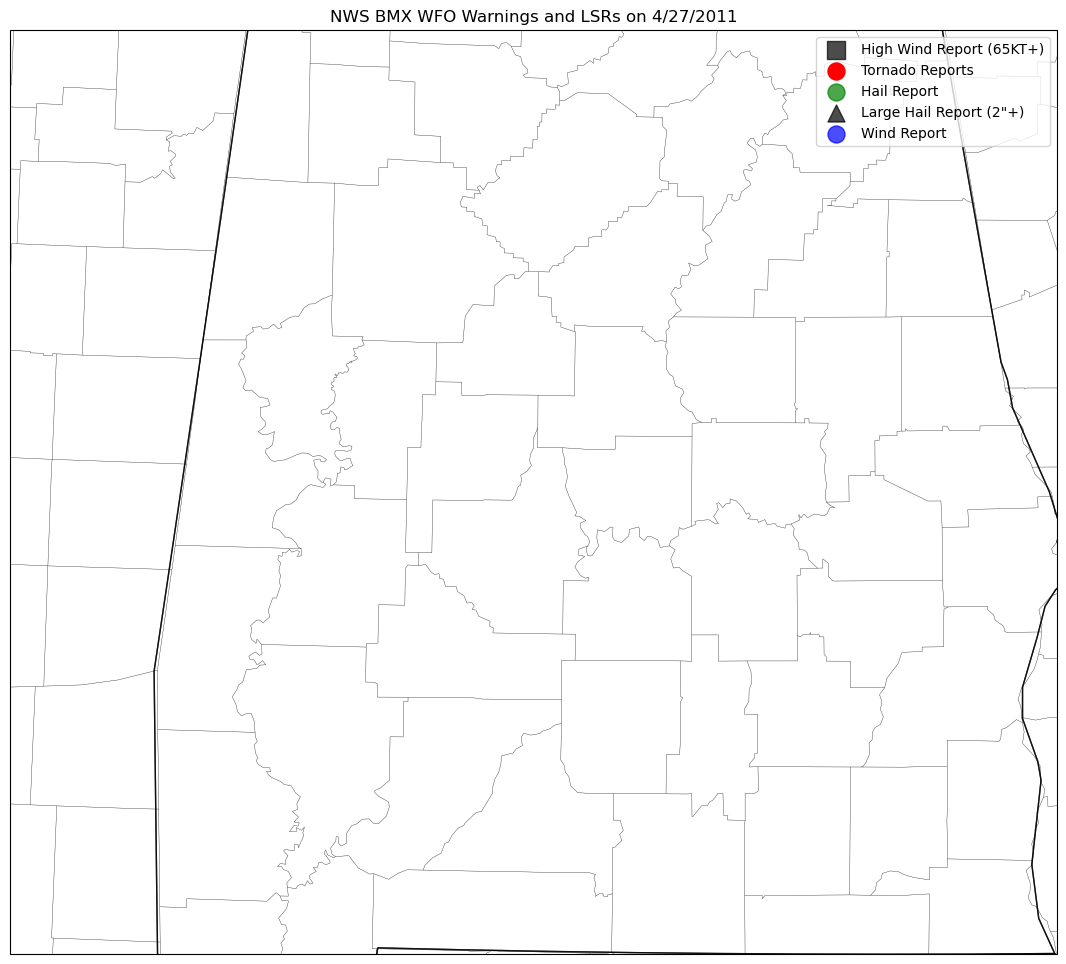

In [22]:
tor_url = '110427_rpts_raw_torn.csv'

df_tor = pd.read_csv(tor_url)

hail_url = '110427_rpts_raw_hail.csv'

df_hail = pd.read_csv(hail_url)

wind_url = '110427_rpts_raw_wind.csv'

df_wind = pd.read_csv(wind_url)

print(df_wind)

print(df_wind.columns)

#tor_url = 'https://www.spc.noaa.gov/climo/reports/230615_rpts_torn.csv'

#df_tor = pd.read_csv(tor_url)

#hail_url = 'https://www.spc.noaa.gov/climo/reports/230615_rpts_hail.csv'

#df_hail = pd.read_csv(hail_url)

#wind_url = 'https://www.spc.noaa.gov/climo/reports/230615_rpts_wind.csv'

#df_wind = pd.read_csv(wind_url)

for i in range(len(df_wind['Speed'])):
    value = df_wind['Speed'][i]
    if value != 'UNK':
        try:
            df_wind['Speed'][i] = float(value)
        except ValueError:
            df_wind['Speed'][i] = np.nan

url = 'https://mesonet.agron.iastate.edu/api/1/cow.json?wfo=BMX&begints=2011-04-27T12:00:00Z&endts=2011-04-28T12:00:00Z&hailsize=1&wind=58&phenomena=TO&phenomena=SV&phenomena=MA&phenomena=FF&phenomena=DS&lsrbuffer=15&warningbuffer=1'
response = requests.get(url)
data = response.json()

events = data['events']['features']

warning_data = []

for event in events:
    properties = event['properties']
    geometry = event['geometry']
    
    id = event['id']
    year = properties['year']
    wfo = properties['wfo']
    phenomena = properties['phenomena']
    eventid = properties['eventid']
    issue = properties['issue']
    expire = properties['expire']
    statuses = properties['statuses']
    fcster = properties['fcster']
    significance = properties['significance']
    parea = properties['parea']
    ar_ugcname = properties['ar_ugcname']
    status = properties['status']
    stormreports = properties['stormreports']
    stormreports_all = properties['stormreports_all']
    verify = properties['verify']
    lead0 = properties['lead0']
    areaverify = properties['areaverify']
    sharedborder = properties['sharedborder']

    warning_data.append([id, year, wfo, phenomena, eventid, issue, expire, statuses, fcster, significance,
                         parea, ar_ugcname, status, stormreports, stormreports_all, verify, lead0, areaverify,
                         sharedborder, geometry])

df = pd.DataFrame(warning_data, columns=['id', 'year', 'wfo', 'phenomena', 'eventid', 'issue', 'expire', 'statuses',
                                         'fcster', 'significance', 'parea', 'ar_ugcname', 'status', 'stormreports',
                                         'stormreports_all', 'verify', 'lead0', 'areaverify', 'sharedborder',
                                         'geometry'])

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-85.6, central_latitude=44.3, standard_parallels=(30, 60)))
ax.set_extent([-89, -85, 31, 34.0])

ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), alpha=.75)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', linewidth=0.5)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha = 0.5)

for i in range(len(df_wind['Speed'])):
    value = df_wind['Speed'][i]
    if value != 'UNK':
        try:
            df_wind['Speed'][i] = float(value)
        except ValueError:
            df_wind['Speed'][i] = np.nan

for df in [df_tor, df_hail, df_wind]:
    df['Lat'] = df['Lat'].apply(lambda x: f'{x:.2f}')
    df['Lon'] = df['Lon'].apply(lambda x: f'{-x:.2f}')

for index, row in df_hail.iterrows():
    if row['Size'] >= 200:
        ax.scatter(row['Lon'], row['Lat'],transform=ccrs.PlateCarree(), marker='^', c='black', alpha=0.7, s = 150,zorder=2, label = 'Large Hail Report (2"+)')
    else:
        ax.scatter(row['Lon'], row['Lat'],transform=ccrs.PlateCarree(), c='green', alpha=0.7, s=150,zorder=2, label='Hail Report')

for index, row in df_wind.iterrows():
    if (row['Speed'] != 'UNK' and row['Speed'] > 65):
        ax.scatter(row['Lon'], row['Lat'],transform=ccrs.PlateCarree(), marker = 's', c='black', alpha=0.7, s=150,zorder=2, label='High Wind Report (65KT+)')
    else:
        ax.scatter(row['Lon'], row['Lat'],transform=ccrs.PlateCarree(), c='blue', alpha=0.7, s=150,zorder=2, label='Wind Report')

ax.scatter(df_tor['Lon'].astype(float), df_tor['Lat'].astype(float), transform=ccrs.PlateCarree(), c='red', label='Tornado Reports', s = 150, zorder=2)

handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
plt.legend(unique_handles, unique_labels, loc='upper right')

colors = {'SV': 'yellow', 'TO': 'red', 'FF': 'green', 'MA': 'orange', 'DS': 'brown'}
zorders = {'TO': 3, 'SV': 2, 'MA': 1}

plt.title('NWS BMX WFO Warnings and LSRs on 4/27/2011')

plt.show()